# Import Library

In [1]:
import steamreviews
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import re

# Extract Data

In [2]:
def extract(app_id = 2076040):
    """
    Function to extract reviews from Steam based on app_id and with most helpful filter then returning a dataframe

    Args:
        app_id (int): Steam game id
    
    Returns:
        df (dataframe): Dataframe of reviews
    """
    request_params = dict()
    # Reference: https://partner.steamgames.com/doc/store/getreviews
    # request_params['filter'] = 'recent'
    request_params['language'] = 'english'  # language of the reviews
    request_params['day_range'] = '30'  # maximum range of days

    review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id,
                                                                    chosen_request_params=request_params)
    review_data = list(review_dict['reviews'].values())
    df = pd.json_normalize(review_data)
    return df


#### Scrapping steam reviews

transforming scraped data

In [3]:
def transform(df):
    """
    Function to transform dataframe into a dataframe with only datetime and review column

    Args:
        df (dataframe): Dataframe of reviews

    Returns:
        clean_df (dataframe): Dataframe of reviews with only datetime and review column
    """
    df['time'] = pd.to_datetime(df['timestamp_created'], unit='s')
    df['time'] = df['time'].dt.strftime('%Y-%m-%d')
    df.drop_duplicates(subset=['review'], keep='first', inplace=True)
    clean_df = df[['time', 'review']].reset_index(drop=True).copy()
    clean_df['review'] = clean_df['review'].str.lower()
    return clean_df
    

In [4]:
def transform_2(df_2):
    """
    Function to transform the second data source into a dataframe with aggregating the sum of users per day and 
    datetime column

    Args:
        df_2 (dataframe): Dataframe of Users count per day
    
    Returns:
        clean_df_2 (dataframe): Dataframe of users count per day with datetime column
    """
    clean_df2 = df_2[['DateTime', 'Players']].copy()
    clean_df2['DateTime'] = pd.to_datetime(clean_df2['DateTime'])
    clean_df2['DateTime'] = clean_df2['DateTime'].dt.strftime('%Y-%m-%d')
    clean_df2.rename(columns={'DateTime': 'time'}, inplace=True)
    return clean_df2

In [5]:
df = extract(1084600)
clean_df = transform(df)
clean_df

[appID = 1084600] expected #reviews = 5908


,time,review
0,2023-11-08,if your a fan of my time at portia this is tha...
1,2023-11-08,i have this on nintendo switch also love this ...
2,2023-11-08,juegazooooo
3,2023-11-08,very much addicting/chaotic gotta-go and gotta...
4,2023-11-08,it's nice. hits all the right notes for a fun ...
...,...,...
774,2023-11-08,only a few hours in and it seems to be a decen...
775,2023-11-08,really good enjoyable relaxing experience.. it...
776,2023-11-08,lots of fun and lots to do highly recommend
777,2023-11-08,this game deserves more attention! although my...


#### Load users count scraped data

In [6]:
df_2 = pd.read_csv('./data/sandrockv2.csv')
# df_2
clean_df2 = transform_2(df_2)

In [7]:
clean_df2.dtypes

time       object
Players     int64
dtype: object

In [8]:
clean_df2

,time,Players
0,2022-05-26,18683
1,2022-05-27,19612
2,2022-05-28,21778
3,2022-05-29,21162
4,2022-05-30,17540
...,...,...
526,2023-11-03,11835
527,2023-11-04,16806
528,2023-11-05,19735
529,2023-11-06,16388


#### Merging 2 data source

In [9]:
clean_df2

,time,Players
0,2022-05-26,18683
1,2022-05-27,19612
2,2022-05-28,21778
3,2022-05-29,21162
4,2022-05-30,17540
...,...,...
526,2023-11-03,11835
527,2023-11-04,16806
528,2023-11-05,19735
529,2023-11-06,16388


In [10]:
df_combine = pd.merge(clean_df, clean_df2, on='time', how='outer').dropna()
df_combine

,time,review,Players
43,2023-11-07,cute game.,15801.0
44,2023-11-07,love that i'm able to fix up and expand a town...,15801.0
45,2023-11-07,i honestly love this game. i had played portia...,15801.0
46,2023-11-07,bing chilling,15801.0
47,2023-11-07,is fun,15801.0
...,...,...,...
509,2023-10-09,good game!,3019.0
510,2023-10-09,i like it overall but some things are annoying...,3019.0
511,2023-10-09,"just by the content : price ratio alone, this ...",3019.0
512,2023-10-09,"this game is very unique, there isnt many game...",3019.0


In [11]:
df_combine['time'] = pd.to_datetime(df_combine['time'], format='%Y-%m-%d')

# NLP Sentiment Analysis

In [12]:
import nltk
from nltk.corpus import stopwords

# Mendownload stopwords jika belum pernah didownload sebelumnya
nltk.download('stopwords')

# Mengambil set stopwords yang sudah ada dari NLTK
stop_words = set(stopwords.words('english'))

# Baca file stopwords Anda dan tambahkan ke dalam set
with open('./data/stopwords-en.txt', 'r', encoding='utf-8') as file:
    additional_stopwords = file.read().splitlines()
    stop_words.update(additional_stopwords)

print(stop_words)

{"don't", 'greater', 'exactly', 'doing', 'fix', 'better', 'toward', 'z', 'opens', 'reasonably', 'ro', "needn't", 'usefully', "who'd", "i've", 'immediately', 'let', 'always', 'miss', 'whatll', 'sy', 'ao', 'th', 'reserved', "they'll", 'shes', 'who', 'everybody', 'numbers', 'uucp', 'gf', 'a', 'weve', 'shouldnt', 'thereby', 'likewise', 'already', 'wouldn', 'www', 'until', 'aw', 'za', 'goods', 'ours', 'tk', 'less', 'inc.', 'minus', 'net', 'hereafter', 'pw', 'beginnings', 'ci', 'dj', 'li', 'thousand', 'mv', "they've", 'farther', "it'd", 'resulted', 'wasnt', 'alone', 'furthermore', 'tis', 'certainly', 'considering', 'seems', 'don', 'gives', 'rd', 'from', 'lu', "must've", 'nonetheless', 'still', 'vs', 'against', 'aint', 'places', 'course', 'va', 'during', 'yours', 'mil', 'ls', 'affected', 'mine', 'briefly', "i'll", 'has', 'itll', 'states', 'sl', 'downing', 'happens', 'novel', 'sd', 'pages', 'pt', 'causes', 'wish', 'puts', 'sides', 'above', 'nobody', 'specified', 'clear', 'showing', 'vi', 'conc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alghi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def preprocess_tweet(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  # text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('^(\@\w+ ?)+',' ',text)
  text = re.sub(r'\@\w+',' ',text) # Remove every username
  text = re.sub(r'\#\w+',' ',text) # Remove every hashtag
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('/', ' ', text)
  # text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('  +', ' ', text) # Remove extra spaces
  return text

def remove_nonalphanumeric(text):
  text = re.sub('&amp;', ' ', text)  # Mengganti &amp; dengan spasi
  text = re.sub('[^0-9a-zA-Z]+', ' ', text)  # Mengganti semua karakter non-alphanumeric dengan spasi
  text = re.sub('  +', ' ', text)  # Menggabungkan spasi yang berlebih
  return text.strip()  # Menghapus spasi di awal dan akhir string


def remove_stopword(text):
  text = re.sub('[.,!?]','',text)
  text = ' '.join(['' if word in stop_words else word for word in text.split(' ')]) #Mengganti stopword dengan ''
  text = re.sub('  +', ' ', text)
  text = text.title()
  text = text.strip() #Menghapus spasi atau newline di awal dan akhir kalimat yang tidak diperlukan
  return text

In [14]:
def preprocess(text):
  text = preprocess_tweet(text)
  text = remove_nonalphanumeric(text)
  return text


In [16]:
df_combine['review_clean'] = df_combine['review'].apply(preprocess)
df_combine['review_clean'] = df_combine['review_clean'].apply(remove_stopword) 

In [17]:
df_combine.loc[:, ['review', 'review_clean']]

,review,review_clean
43,cute game.,Cute Game
44,love that i'm able to fix up and expand a town...,Love Expand Town Wait Add Stuff Multiplayer
45,i honestly love this game. i had played portia...,Honestly Love Game Played Portia Release Play ...
46,bing chilling,Bing Chilling
47,is fun,Fun
...,...,...
509,good game!,Game
510,i like it overall but some things are annoying...,Annoying Timeline Events Quick Handle Talk Wor...
511,"just by the content : price ratio alone, this ...",Content Price Ratio Worth Penny Genuinely Wait...
512,"this game is very unique, there isnt many game...",Game Unique Games Searched Romance Games Time ...


In [18]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english", tokenizer="siebert/sentiment-roberta-large-english", truncation=True)

In [19]:
# Menerapkan model dalam batch dan menyimpan hasilnya dalam kolom 'sentiment_label'
df_combine['sentiment_label'] = [result['label'] for result in nlp(df_combine['review'].tolist())]


In [20]:
df_combine['positive'] = df_combine['sentiment_label'].apply(lambda x: 1 if x == 'POSITIVE' else 0)
df_combine['negative'] = df_combine['sentiment_label'].apply(lambda x: 1 if x == 'NEGATIVE' else 0)

In [58]:
df_combine['sentiment_ratio'] = df_combine.groupby('time')['positive'].transform('sum') / (df_combine.groupby('time')['negative'].transform('sum') + df_combine.groupby('time')['positive'].transform('sum'))

In [21]:
df_combine

,time,review,Players,review_clean,sentiment_label,positive,negative
43,2023-11-07,cute game.,15801.0,Cute Game,POSITIVE,1,0
44,2023-11-07,love that i'm able to fix up and expand a town...,15801.0,Love Expand Town Wait Add Stuff Multiplayer,POSITIVE,1,0
45,2023-11-07,i honestly love this game. i had played portia...,15801.0,Honestly Love Game Played Portia Release Play ...,POSITIVE,1,0
46,2023-11-07,bing chilling,15801.0,Bing Chilling,POSITIVE,1,0
47,2023-11-07,is fun,15801.0,Fun,POSITIVE,1,0
...,...,...,...,...,...,...,...
509,2023-10-09,good game!,3019.0,Game,POSITIVE,1,0
510,2023-10-09,i like it overall but some things are annoying...,3019.0,Annoying Timeline Events Quick Handle Talk Wor...,POSITIVE,1,0
511,2023-10-09,"just by the content : price ratio alone, this ...",3019.0,Content Price Ratio Worth Penny Genuinely Wait...,POSITIVE,1,0
512,2023-10-09,"this game is very unique, there isnt many game...",3019.0,Game Unique Games Searched Romance Games Time ...,POSITIVE,1,0


In [22]:
df_combine['sentiment_ratio'] = df_combine['positive'] / (df_combine['negative'] + df_combine['positive'])

In [26]:
df_combine['positive_count'] = df_combine.groupby('time')['positive'].transform('sum')
df_combine['negative_count'] = df_combine.groupby('time')['negative'].transform('sum')

In [28]:
df_combine['sentiment_ratio'] = df_combine.groupby('time')['positive'].transform('sum') / (df_combine.groupby('time')['negative'].transform('sum') + df_combine.groupby('time')['positive'].transform('sum'))

In [29]:
df_combine

,time,review,Players,review_clean,sentiment_label,positive,negative,sentiment_ratio,positive_count,negative_count
43,2023-11-07,cute game.,15801.0,Cute Game,POSITIVE,1,0,0.75,30,10
44,2023-11-07,love that i'm able to fix up and expand a town...,15801.0,Love Expand Town Wait Add Stuff Multiplayer,POSITIVE,1,0,0.75,30,10
45,2023-11-07,i honestly love this game. i had played portia...,15801.0,Honestly Love Game Played Portia Release Play ...,POSITIVE,1,0,0.75,30,10
46,2023-11-07,bing chilling,15801.0,Bing Chilling,POSITIVE,1,0,0.75,30,10
47,2023-11-07,is fun,15801.0,Fun,POSITIVE,1,0,0.75,30,10
...,...,...,...,...,...,...,...,...,...,...
509,2023-10-09,good game!,3019.0,Game,POSITIVE,1,0,1.00,5,0
510,2023-10-09,i like it overall but some things are annoying...,3019.0,Annoying Timeline Events Quick Handle Talk Wor...,POSITIVE,1,0,1.00,5,0
511,2023-10-09,"just by the content : price ratio alone, this ...",3019.0,Content Price Ratio Worth Penny Genuinely Wait...,POSITIVE,1,0,1.00,5,0
512,2023-10-09,"this game is very unique, there isnt many game...",3019.0,Game Unique Games Searched Romance Games Time ...,POSITIVE,1,0,1.00,5,0


C:\Users\alghi\AppData\Local\Temp\ipykernel_31476\2630146847.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_combine, x='sentiment_ratio', y='Players', ci=None)


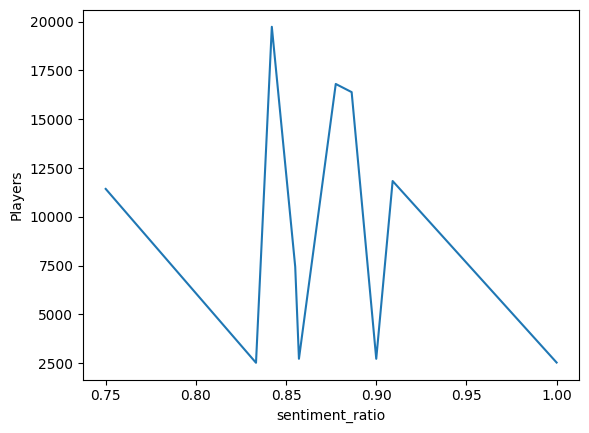

In [31]:
sns.lineplot(data=df_combine, x='sentiment_ratio', y='Players', ci=None)
plt.show()

C:\Users\alghi\AppData\Local\Temp\ipykernel_31476\2481753522.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_combine, x='time', y='Players', ci=None)


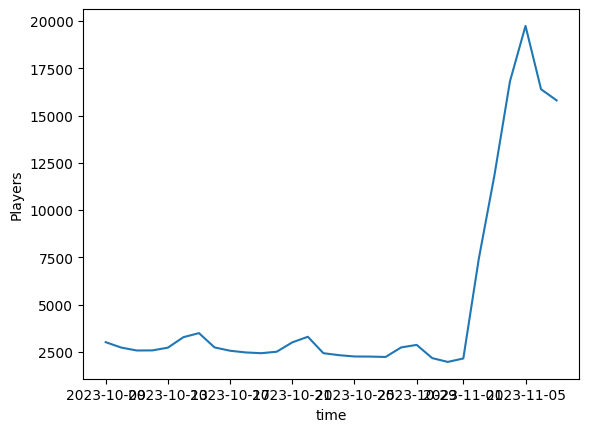

In [34]:
sns.lineplot(data=df_combine, x='time', y='Players', ci=None)
plt.show()

In [52]:
daily_sentiment = df_combine.set_index('time')[['sentiment_ratio', 'positive_count', 'negative_count', 'Players']].resample('D').mean()

comparing sentiment ratio with players count

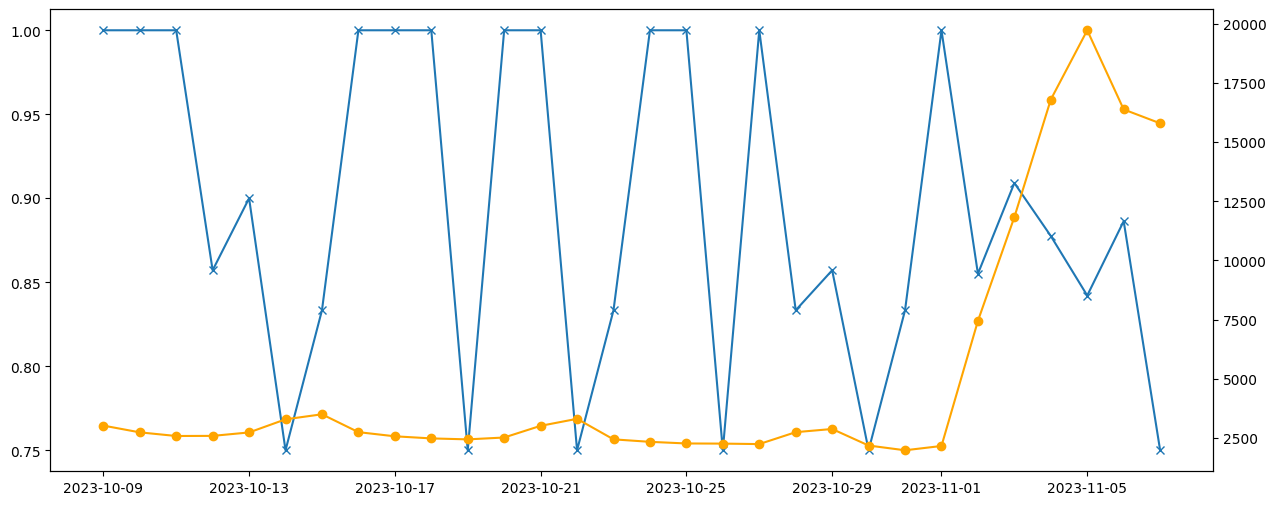

In [57]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(daily_sentiment['sentiment_ratio'].index, daily_sentiment['sentiment_ratio'], marker='x')
#combine the y axis
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(daily_sentiment.index, daily_sentiment['Players'], color='orange', marker='o')
plt.xticks(rotation=45)
plt.show()

corellation plot between players and sentiment ratio

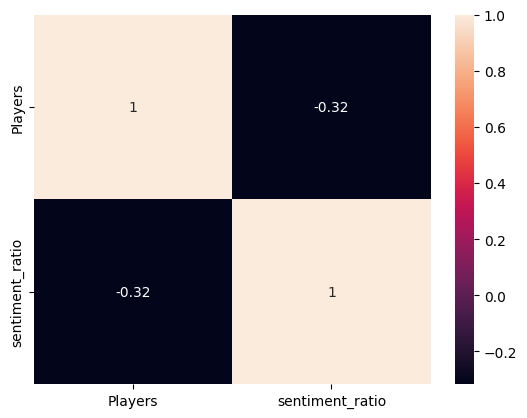

In [61]:
sns.heatmap(df_combine[['Players', 'sentiment_ratio']].corr(), annot=True)
plt.show()

wordcloud of positive and negative reviews, to get insight of what players like and dislike

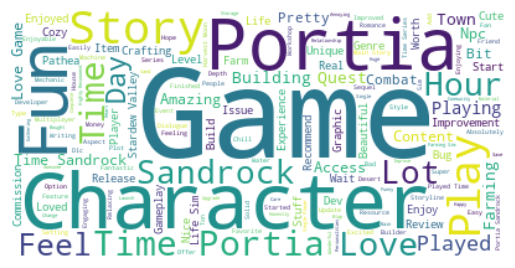

In [63]:
#create wordcloud from positive reviews
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

df_positive = df_combine[df_combine['sentiment_label'] == 'POSITIVE']

text = " ".join(review for review in df_positive.review_clean)

wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

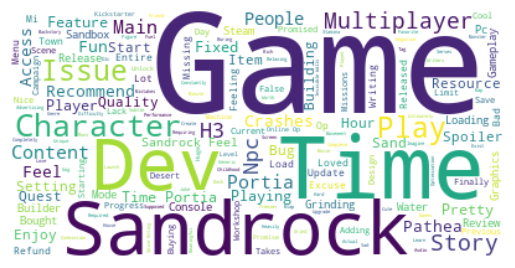

In [64]:
df_negative = df_combine[df_combine['sentiment_label'] == 'NEGATIVE']

text = " ".join(review for review in df_negative.review_clean)

wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [65]:
#getting summary from positive reviews
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string
import re

def get_summary(text):
    #remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #remove numbers
    text = re.sub(r'\d+', '', text)
    #tokenize
    tokens = word_tokenize(text)
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    #get frequency distribution
    fdist = FreqDist(tokens)
    #get top 5 most frequent words
    top_words = fdist.most_common(5)
    return top_words

df_positive['summary'] = df_positive['review'].apply(get_summary)


C:\Users\alghi\AppData\Local\Temp\ipykernel_31476\1425729748.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive['summary'] = df_positive['review'].apply(get_summary)


In [69]:
# getting summary of positive review with LDA
from gensim import corpora
import gensim

def get_summary_lda(text):
    #remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #remove numbers
    text = re.sub(r'\d+', '', text)
    #tokenize
    tokens = word_tokenize(text)
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    #create dictionary
    dictionary = corpora.Dictionary([tokens])
    #create corpus
    corpus = [dictionary.doc2bow(tokens)]
    #create lda model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=1, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    #get top 5 words
    top_words = lda_model.print_topics()[0][1]
    top_words = top_words.split('"')[1::2]
    return top_words

df_positive['summary_lda'] = df_positive['review'].apply(get_summary_lda)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\alghi\AppData\Local\Temp\ipykernel_31476\190624386.py:34 in <module>                    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\alghi\\AppData\\Local\\Temp\\ipykernel_31476\\190624386.py'                          │
│                                                                                                  │
│ C:\Users\alghi\AppData\Roaming\Python\Python310\site-packages\pandas\core\series.py:4771 in      │
│ apply                                                                                            │
│                                                                                                  │
│   4768 │   │   Helsinki    2.484907                                                              │
│   4769 │   │   dtype: float64                                                                    │
│   4770 │   │   """                                                                               │
│ ❱ 4771 │   │   return SeriesApply(self, func, convert_dtype, args, kwargs).apply()               │
│   4772 │                                                                                         │
│   4773 │   def _reduce(                                                                          │
│   4774 │   │   self,                                                                             │
│                                                                                                  │
│ C:\Users\alghi\AppData\Roaming\Python\Python310\site-packages\pandas\core\apply.py:1123 in apply │
│                                                                                                  │
│   1120 │   │   │   return self.apply_str()                                                       │
│   1121 │   │                                                                                     │
│   1122 │   │   # self.f is Callable                                                              │
│ ❱ 1123 │   │   return self.apply_standard()                                                      │
│   1124 │                                                                                         │
│   1125 │   def agg(self):                                                                        │
│   1126 │   │   result = super().agg()                                                            │
│                                                                                                  │
│ C:\Users\alghi\AppData\Roaming\Python\Python310\site-packages\pandas\core\apply.py:1174 in       │
│ apply_standard                                                                                   │
│                                                                                                  │
│   1171 │   │   │   │   mapped = obj._values.map(f)                                               │
│   1172 │   │   │   else:                                                                         │
│   1173 │   │   │   │   values = obj.astype(object)._values                                       │
│ ❱ 1174 │   │   │   │   mapped = lib.map_infer(                                                   │
│   1175 │   │   │   │   │   values,                                                               │
│   1176 │   │   │   │   │   f,                                                                    │
│   1177 │   │   │   │   │   convert=self.convert_dtype,                                           │
│                                                                                                  │
│ c:\Users\alghi\Documents\Coolyeah\Semester 5\Rekayasa Data\tugas etl\pandas\_libs\lib.pyx:2924   │
│ in pandas._libs.lib.map_infer                              